In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import RFE 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import mutual_info_classif 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz 
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn import svm 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import recall_score 
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [3]:
data=pd.read_csv('/bank.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## **Label Enocder**

In [4]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


In [5]:
data = MultiColumnLabelEncoder(columns = ['job','marital','education', 'default','housing','loan','contact','month','poutcome','deposit']).fit_transform(data)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


## **Checking if data is balanced**

In [6]:
target_count = data.deposit.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

Class 0: 5873
Class 1: 5289
Proportion: 1.11 : 1


Our data is balanced ; prportion close to 1 

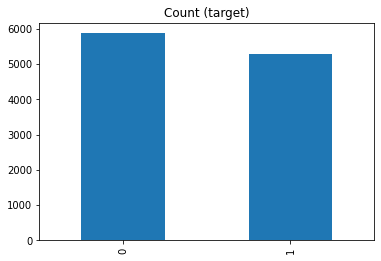

In [7]:
target_count.plot(kind='bar', title='Count (target)')

## **Splitting data into Train Test** 

In [8]:
# features
X = data.drop('deposit', axis=1)
# target
y=data['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
columns = X_train.columns
print("len(X_train)=",len(X_train))
print("len(y_train)=",len(y_train))

#X_train.info()
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))


len(X_train)= 7813
len(y_train)= 7813
(7813, 16)
(7813,)
(3349, 16)
(3349,)


## **Logistic Regression**

In [10]:
logreg=LogisticRegression()
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"],"solver": ['liblinear']}
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)
print("tuned hyperparameters:(best parameters ",logreg_cv.best_params_)
print("accuracy ",logreg_cv.best_score_)

tuned hyperparameters:(best parameters  {'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy  0.7999498970105217


In [11]:
logreg=LogisticRegression(C=100.0,penalty="l2",solver="liblinear",random_state=0)

In [23]:
rfe = RFE(estimator=logreg) #, n_features_to_select=10)
rfe.fit(X_train,y_train)
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))


Column: 0, Selected False, Rank: 4.000
Column: 1, Selected False, Rank: 3.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 9.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 5.000
Column: 10, Selected False, Rank: 2.000
Column: 11, Selected False, Rank: 7.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected False, Rank: 8.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 6.000


In [27]:
rfe.predict(X_test)
rfe.score(X_test,y_test)

0.6422812779934308

In [25]:
logreg.fit(X_train,y_train)

LogisticRegression(C=100.0, random_state=0, solver='liblinear')

In [28]:
logreg.predict(X_test)
logreg.score(X_test,y_test)

0.7945655419528217

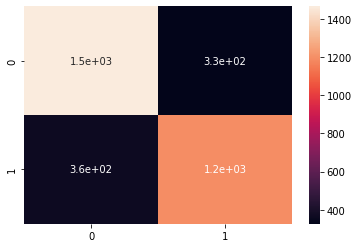

In [29]:
confusion=confusion_matrix(y_test, logreg.predict(X_test))
sns.heatmap(confusion,annot=True)

In [30]:
logreg1=LogisticRegression(C=10.0,penalty="l1",solver="liblinear",random_state=0)

In [31]:
logreg1.fit(X_train,y_train)
logreg1.predict(X_test)
logreg1.score(X_test,y_test)

0.7954613317408181

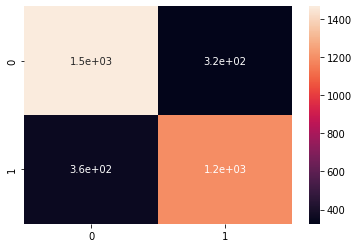

In [ ]:
confusion=confusion_matrix(y_test, logreg1.predict(X_test))
sns.heatmap(confusion,annot=True)

In [32]:
rec=recall_score(y_test,logreg.predict(X_test))
rec

0.7675016056518946

In [33]:
rec=recall_score(y_test,logreg1.predict(X_test))
rec

0.7687861271676301

In [37]:
roc1=logreg.predict(X_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, logreg.predict(X_test))

In [38]:
 print('roc_auc_score for Logisic regression: ', roc_auc_score(y_test, roc1))

roc_auc_score for Logisic regression:  0.7927909813973759


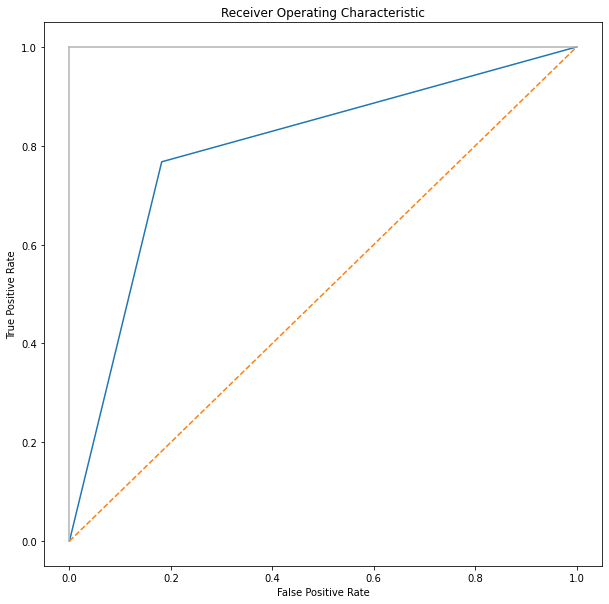

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test, logreg.predict(X_test))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **Decision Tree**

In [39]:
grid = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12]}
dec_tree= GridSearchCV(DecisionTreeClassifier(), grid, cv=5)
dec_tree.fit(X_train,y_train)
print("tuned hyperparameters:(best parameters ",dec_tree.best_params_)
print("accuracy ",dec_tree.best_score_)

tuned hyperparameters:(best parameters  {'criterion': 'entropy', 'max_depth': 7}
accuracy  0.8099339478972363


best parameters = {'criterion'='entropy',  'max_depth'=12,   'max_features'='auto'}

In [40]:
dec_tree_clf=DecisionTreeClassifier(criterion='entropy',max_depth=7)

In [41]:
dec_tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [42]:
dec_tree_clf.predict(X_test)
dec_tree_clf.score(X_test,y_test)

0.8083009853687668

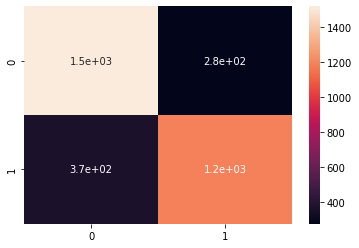

In [43]:
confusion=confusion_matrix(y_test, dec_tree_clf.predict(X_test))
sns.heatmap(confusion,annot=True)

In [44]:
roc2=dec_tree_clf.predict(X_test)
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test, roc2)

In [45]:
dec_tree_clf_2=DecisionTreeClassifier(criterion='gini',max_depth=10,max_features='log2')
dec_tree_clf_2.fit(X_train,y_train)
dec_tree_clf_2.predict(X_test)
dec_tree_clf_2.score(X_test,y_test)

0.7763511495968946

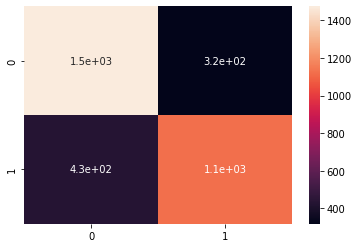

In [46]:
confusion=confusion_matrix(y_test, dec_tree_clf_2.predict(X_test))
sns.heatmap(confusion,annot=True)

In [47]:
rec=recall_score(y_test,dec_tree_clf.predict(X_test))
rec

0.7642903018625562

In [48]:
rec=recall_score(y_test,dec_tree_clf_2.predict(X_test))
rec

0.7231856133590238

On remarque que le classifier 1 est plus performant que le classifier 2 /  0.78 et 0.739

## **Random Forest**

In [49]:
random_forest_clf= RandomForestClassifier(random_state=10, class_weight = 'balanced')
param_grid = { 
    'n_estimators': [50, 100],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10,11,12],
    'criterion' :['gini', 'entropy']
}
skf=StratifiedKFold(n_splits=5,shuffle=False, random_state=None)
CV_random_forest = GridSearchCV(estimator=random_forest_clf, param_grid=param_grid, cv= skf, scoring = 'roc_auc')
CV_random_forest.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'n_estimators': [50, 100]},
             scoring='roc_auc')

In [50]:
print("tuned hyperparameters:(best parameters ",CV_random_forest.best_params_)
print("accuracy ",CV_random_forest.best_score_)


tuned hyperparameters:(best parameters  {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 100}
accuracy  0.9145327344525102


In [51]:
random_clf=RandomForestClassifier(criterion='entropy',max_depth=12,n_estimators=100,)

In [52]:
random_clf.fit(X_train,y_train)
random_clf.predict(X_test)
random_clf.score(X_test,y_test)

0.8453269632726187

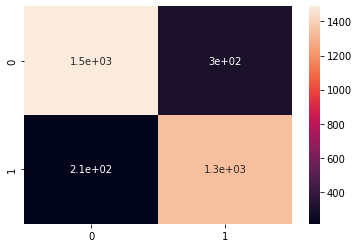

In [53]:
confusion=confusion_matrix(y_test, random_clf.predict(X_test))
sns.heatmap(confusion,annot=True)


In [54]:
rec=recall_score(y_test,random_clf.predict(X_test))
rec

0.8625561978163134

In [55]:
roc3=random_clf.predict(X_test)
fpr3, tpr3, threshold3 = metrics.roc_curve(y_test, roc3)

## **SVM**

In [56]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 2,cv=10)
grid.fit(X_train, y_train)
print(grid.best_estimator_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.9s
[CV] END .......................C=0.1, gamma=0

KeyboardInterrupt: ignored

In [57]:
svm_clf=SVC(C=10,gamma=0.1,kernel='rbf')

In [58]:
svm_clf.fit(X_train,y_train)
svm_clf.predict(X_test)
svm_clf.score(X_test,y_test)

0.5347865034338608

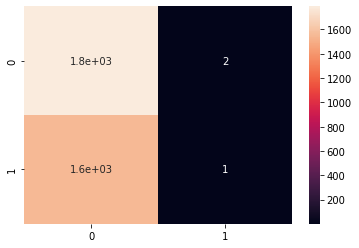

In [59]:
confusion=confusion_matrix(y_test, svm_clf.predict(X_test))
sns.heatmap(confusion,annot=True)

In [60]:
rec=recall_score(y_test,svm_clf.predict(X_test))
rec

0.0006422607578676942

In [63]:
roc4=random_clf.predict(X_test)
fpr4, tpr4, threshold4 = metrics.roc_curve(y_test, roc4)

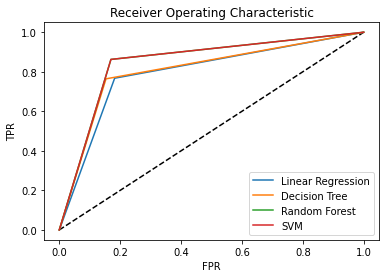

In [64]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Linear Regression")
plt.plot(fpr2, tpr2, label= "Decision Tree")
plt.plot(fpr3, tpr3, label= "Random Forest")
plt.plot(fpr4, tpr4, label= "SVM")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()